In [1]:
#performing grid scan from A/gamma parameter space to n_T/r parameter space

import sys
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

print (sys.version)

3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]


In [2]:
#functions
def gev_to_mpci(gev):
    return gev * 1.5626 * 1e38
def hz_to_mpci(hz):
    return hz * 1.0286 * 1e14
def hzi_to_mpc(hzi):
    return hzi / (1.0286 * 1e14)

In [3]:
#setup
#tau: conformal time, a: scale factor, k: wavenumber (comoving)
#using natural units, hbar = c = 1, working in mpc

#constants
c = 3 * 1e8
h_0 = 0.7 
H_0 = h_0 * (1e5 / c) #maggiore, eq 17.5. units: mpc^-1

Omega_R = 4.184 * 1e-5 * (h_0 ** -2) #maggiore 17.79
Omega_M = 0.3 #maggiore 17.80
Omega_L = 1 - Omega_R - Omega_M #see section below maggiore 17.80
# Lambda = (1 / 3.24078) * 1e-6 #from wikipedia (converted), units: mpc^-2

#RD/MD equilibrium, maggiore values
a_eq = Omega_R / Omega_M #maggiore 17.83
tau_0 = 0.879 * 2 / (H_0 * math.sqrt(Omega_M))
tau_star = (2 * math.sqrt(Omega_R)) / (H_0 * Omega_M)
tau_eq = (math.sqrt(2) - 1) * tau_star
tau_dec = 2.55

k_eq = 0.073 * Omega_M * h_0**2 #from papers

#inflationary stuff
A_s = 2.1e-9
yr = hzi_to_mpc(1 / (3.17e-8))
kstar = 0.05 #mpc^-1
fstar = hz_to_mpci(7.7e-17) # = k * c / (2pi)

#MD/lambdaD equilibrium (?)
a_eq2 = (Omega_M / Omega_L) ** (1/3)

#from mukoyama BT mg paper
# H_inf = gev_to_mpci(1e8)
# m_g1 = 0.5 * H_inf #or 0.8

m_g = 1e9 * H_0 #from emir, m < 1e-5 Hz
# m_g2 = gev_to_mpci(7.6e-29)

tau_off = tau_eq * (1/2) #chosen somewhat arbitrarily
# print(m_g1, m_g2)

In [4]:
def conf_ellip(mu, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    sigma_x = np.sqrt(cov[0, 0])
    sigma_y = np.sqrt(cov[1, 1])
    pearson = cov[0, 1] / (sigma_x * sigma_y)
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    scale_x = sigma_x * n_std
    mean_x = mu[0]

    scale_y = sigma_y * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    ax.set_xlim([mean_x - sigma_x * 3, mean_x + sigma_x * 3])
    ax.set_ylim([mean_y - sigma_y * 3, mean_y + sigma_y * 3])   
     
    ax.add_patch(ellipse)
    return ellipse

def ellipse_contains(mu, cov, n_std, pt):
    m_x, m_y = mu[0], mu[1]
    s_x = np.sqrt(cov[0, 0])
    s_y = np.sqrt(cov[1, 1])
    p = cov[0, 1] / (s_x * s_y)
    x, y = pt[0], pt[1]
    lhs = (1 - p**2) * (s_x**2) * (s_y**2)*(n_std**2)
    rhs = (s_y * (x - m_x))**2 + (s_x * (y - m_y))**2 - 2 * p * s_x * s_y * (x - m_x) * (y - m_y)
    return (rhs <= lhs)


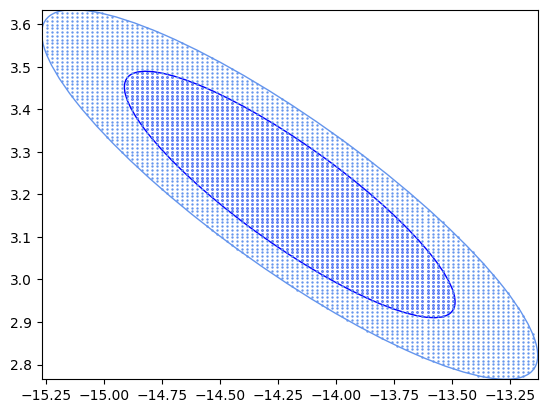

In [5]:
#plot A/gamma posterior approximation, from Vagnozzi paper
mu15 = np.array([-14.2, 3.2])
cov15 = np.array([[0.127, -0.045], [-0.045, 0.021]])

#my approximations, see grid_scan_chains
mu1 = np.array([3.24561639, -14.19797796])
cov1 = np.array([[ 0.12879073, -0.04489819], [-0.04489819,  0.01912812]])

fig, axs = plt.subplots(1, 1)
# axs.set_xlim([2, 5])
# axs.set_ylim([-15, -13])
e2 = conf_ellip(mu15, cov15, axs, 2, edgecolor = 'blue', ls = "-")
e3 = conf_ellip(mu15, cov15, axs, 3, edgecolor = 'cornflowerblue', ls = "-")

#transfer gridscan from A/gamma to n_T/r
m_x15, m_y15 = mu15[0], mu15[1]
s_x15 = np.sqrt(cov15[0, 0])
s_y15 = np.sqrt(cov15[1, 1])
p15 = cov15[0, 1] / (s_x15 * s_y15)

dim_pts = 100
logA, gamma = np.meshgrid(
    np.linspace(m_x15 - 3*s_x15, m_x15 + 3*s_x15, dim_pts),
    np.linspace(m_y15 - 3*s_y15, m_y15 + 3*s_y15, dim_pts))
# plt.scatter(logA, gamma, s = 1)
pairs = list(zip(np.ravel(logA), np.ravel(gamma)))

two_pairs = list(filter(lambda pt: ellipse_contains(mu15, cov15, 2, pt), pairs))
two_pairs_logA = [a for (a, b) in two_pairs]
two_pairs_gamma = [b for (a, b) in two_pairs]
axs.scatter(two_pairs_logA, two_pairs_gamma, s = 0.5, c = 'blue', zorder = 0)

three_pairs = list(filter(lambda pt: ellipse_contains(mu15, cov15, 3, pt), pairs))
three_pairs_logA = [a for (a, b) in three_pairs]
three_pairs_gamma = [b for (a, b) in three_pairs]
axs.scatter(three_pairs_logA, three_pairs_gamma, s = 0.5, c = 'cornflowerblue')

plt.show()


In [ ]:
def logAgamma_to_n_Tlogr(pt, s1):
    logA, gamma = pt[0], pt[1]
    n_T = 5 - gamma
    C = (Omega_M / Omega_L) * np.sqrt((9 * s1 * A_s) / (8 * np.pi**2 * tau_0**4 * k_eq**2)) * yr
    r = (10**logA / C)**2 * ((fstar * yr)**(5 - gamma))
    return (n_T, np.log10(r))

In [ ]:
# s1_GR = 5/2 #GR
s1_GR = 5/8 #GR
two_pairs_nTlogR = list(map(lambda pt: logAgamma_to_n_Tlogr(pt, s1_GR), two_pairs))
two_pairs_nT = [a for (a, b) in two_pairs_nTlogR]
two_pairs_logR = [b for (a, b) in two_pairs_nTlogR]
plt.scatter(two_pairs_nT, two_pairs_logR, s = 0.5, c = 'blue')

three_pairs_nTlogR = list(map(lambda pt: logAgamma_to_n_Tlogr(pt, s1_GR), three_pairs))
three_pairs_nT = [a for (a, b) in three_pairs_nTlogR]
three_pairs_logR = [b for (a, b) in three_pairs_nTlogR]
plt.scatter(three_pairs_nT, three_pairs_logR, s = 0.5, c = 'cornflowerblue', zorder = 0)

plt.xlim((0.5, 3))
plt.ylim((-20, 0))